In [ ]:
import pandas as pd
import numpy as np
import json
import zipfile
import os
import math
from collections import Counter
from typing import Tuple, Dict, List
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from collections import Counter
import random
import dask
import dask.dataframe as dd
from dask.distributed import Client, progress
import time




#### CHANGE THE VALUES IN THE CELL BELOW
##### It should correspond to the amount of .json files you want to read and the filepath were your archive.zip folder is that you downloaded from kaggle at the following link (https://www.kaggle.com/datasets/himanshuwagh/spotify-million/data)
##### **DO NOT EXCTRACT THE DATA, THE SCRIPT READS DIRECTLY FROM THE ZIP FOLDER**

In [2]:
#CHANGE THE VALUES HERE

amount_of_json_files_to_read = 3
zip_path = "C:/Users/Clara/Downloads/archive.zip"
os.chdir( "C:/Users/Clara/Downloads")

In [3]:
with open('spotify-million-metadata.json', 'r') as f:
    data = json.load(f)

In [4]:
playlist_rows = []
track_rows = []
file_rows = []


In [5]:
with zipfile.ZipFile(zip_path, 'r') as z:
    json_files = [f for f in z.namelist() if f.startswith("data/") and f.endswith(".json")]
    json_files.sort()
    
    for filename in json_files[:amount_of_json_files_to_read]:
        print(f"Reading {filename}...")
        with z.open(filename) as f:
            parsed = json.loads(f.read().decode("utf-8"))
            
            #metadata for file
            info = parsed.get("info", {})
            file_rows.append({
                "filename": filename,
                **info
            })
            
            #metadata playlist
            for pl in parsed["playlists"]:
                unique_artists = len({t["artist_name"] for t in pl["tracks"]})
                playlist_entry = {**pl}
                playlist_entry["num_artists"] = unique_artists
                playlist_entry["filename"] = filename
                playlist_rows.append(playlist_entry)
                
                #track metadata
                for track in pl["tracks"]:
                    track_entry = {**track}
                    track_entry["pid"] = pl.get("pid")
                    track_entry["filename"] = filename
                    track_rows.append(track_entry)


Reading data/mpd.slice.0-999.json...
Reading data/mpd.slice.1000-1999.json...
Reading data/mpd.slice.10000-10999.json...


In [6]:
df_playlists = pd.DataFrame(playlist_rows)
df_tracks = pd.DataFrame(track_rows)
df_files = pd.DataFrame(file_rows)

In [7]:
#df_full = df_tracks_playlists.merge(df_files, on="filename")
df_full= df_playlists.drop(columns = ["tracks"]).merge(df_tracks, on=["pid", "filename"], suffixes=("_playlist", "_track"))
df_full["track_id"] = df_full["track_uri"].str.split(":").str[-1]
df_full.head()

,name,collaborative,pid,modified_at,num_tracks,num_albums,num_followers,num_edits,duration_ms_playlist,num_artists,...,description,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms_track,album_name,track_id
0,Throwbacks,false,0,1493424000,52,47,1,6,11532414,37,...,NaN,0,Missy Elliott,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,The Cookbook,0UaMYEvWZi0ZqiDOoHU3YI
1,Throwbacks,false,0,1493424000,52,47,1,6,11532414,37,...,NaN,1,Britney Spears,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,spotify:artist:26dSoYclwsYLMAKD3tpOr4,Toxic,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800,In The Zone,6I9VzXrHxO9rA9A5euc8Ak
2,Throwbacks,false,0,1493424000,52,47,1,6,11532414,37,...,NaN,2,Beyoncé,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Crazy In Love,spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933,Dangerously In Love (Alben für die Ewigkeit),0WqIKmW4BTrj3eJFmnCKMv
3,Throwbacks,false,0,1493424000,52,47,1,6,11532414,37,...,NaN,3,Justin Timberlake,spotify:track:1AWQoqb9bSvzTjaLralEkT,spotify:artist:31TPClRtHm23RisEBtV3X7,Rock Your Body,spotify:album:6QPkyl04rXwTGlGlcYaRoW,267266,Justified,1AWQoqb9bSvzTjaLralEkT
4,Throwbacks,false,0,1493424000,52,47,1,6,11532414,37,...,NaN,4,Shaggy,spotify:track:1lzr43nnXAijIGYnCT8M8H,spotify:artist:5EvFsr3kj42KNv97ZEnqij,It Wasn't Me,spotify:album:6NmFmPX56pcLBOFMhIiKvF,227600,Hot Shot,1lzr43nnXAijIGYnCT8M8H


In [ ]:
print(df_full.shape[0] == df_playlists["num_tracks"].sum()) #dq OK

In [8]:
kaggle = pd.read_csv("spotify_data.csv")
kaggle.head()
kaggle.columns

Index(['Unnamed: 0', 'artist_name', 'track_name', 'track_id', 'popularity',
       'year', 'genre', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature'],
      dtype='object')

In [9]:

# Standardize track URI/id if needed
# e.g., if Kaggle has a Spotify URL, strip it to get the URI or ID

# Join audio features onto df_full at track level
audio_cols = ["track_id","genre", "danceability", "energy", "valence", "tempo", "acousticness", "instrumentalness", "liveness"]  # adjust to actual cols
kaggle_audio = kaggle[audio_cols].drop_duplicates(subset=["track_id"])

df_full_enriched = df_full.merge(kaggle_audio, on="track_id", how="left")
df_full_enriched.head(100).to_excel("head.xlsx")

<ipython-input-9-b6acca962c0d>:9: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.8' currently installed).
  df_full_enriched.head(100).to_excel("head.xlsx")


**Basic Visualization**

In [10]:
# ---------- Utility functions ----------

def safe_nunique(s: pd.Series) -> int:
    return int(s.dropna().nunique()) if s is not None else 0

def entropy_from_counts(counts):
    if not counts:
        return 0.0
    freqs = np.array(counts, dtype=float)
    probs = freqs / freqs.sum()
    probs = probs[probs > 0]
    ent = -np.sum(probs * np.log2(probs))
    max_ent = math.log2(len(probs)) if len(probs) > 1 else 1.0
    return float(ent / max_ent) if max_ent > 0 else 0.0

def top_k_from_series(s: pd.Series, k: int = 5):
    if s is None:
        return []
    vc = s.dropna().value_counts().head(k)
    return list(zip(vc.index.tolist(), vc.tolist()))

def repr_col(group: pd.DataFrame, col: str, default=None):
    if col in group.columns:
        vals = group[col].dropna().unique()
        return vals[0] if len(vals) > 0 else default
    return default


# ---------- Main aggregation function ----------
def compute_playlist_aggregates(df_full: pd.DataFrame):
    """
    Returns:
      - df_agg: one row per playlist with all duration metrics in MILLISECONDS and MINUTES (for readability)
      - extras: dict with top artists and top tracks per playlist
    """

    required_cols = [
        'pid', 'artist_uri', 'album_uri', 'track_uri', 'duration_ms_track'
    ]
    missing = [c for c in required_cols if c not in df_full.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")
    
    audio_columns = [
        c for c in [
            "danceability", "energy", "valence", "tempo",
            "acousticness", "instrumentalness", "liveness",
            "speechiness", "loudness"
        ] if c in df_full.columns
    ]    
    g = df_full.groupby('pid', as_index=False)

    agg_rows = []
    extras = {'top_artists': {}, 'top_tracks': {}}

    for pid, group in g:
        row = {}

        # ---------- Identifiers ----------
        row['pid'] = pid
        row['playlist_name'] = repr_col(group, 'name')
        #row['description'] = repr_col(group, 'description') #not super relevant here, most people don't put a description

        # ---------- Own Counts ----------
        #row['num_tracks_actual'] = int(group.shape[0]) #doesn't work, to be investigateed 
        row['num_unique_tracks'] = safe_nunique(group['track_uri'])
        row['num_unique_artists'] = safe_nunique(group['artist_uri'])
        row['num_unique_albums'] = safe_nunique(group['album_uri'])
        
        # ---------- Playlist-level metadata ----------
        row['num_tracks_reported'] = int(repr_col(group, 'num_tracks', 0))
        row['num_albums_reported'] = int(repr_col(group, 'num_albums', 0))
        row['num_artists_reported'] = int(repr_col(group, 'num_artists', 0))
        row['num_followers'] = int(repr_col(group, 'num_followers', 0))
        row['num_edits'] = int(repr_col(group, 'num_edits', 0))
        #row['collaborative'] = bool(repr_col(group, 'collaborative', False)) collaborative is not stored as a boolean
        # Get the value as string first (or default "false")
        collab_str = str(repr_col(group, 'collaborative', 'false')).lower()
        # Convert to boolean
        row['collaborative'] = collab_str == 'true'
        row['modified_at'] = repr_col(group, 'modified_at')

        # ---------- DURATIONS (IN MINUTES) ----------
        total_ms = group['duration_ms_track'].sum(skipna=True)
        mean_ms = group['duration_ms_track'].mean(skipna=True)
        median_ms = group['duration_ms_track'].median(skipna=True)
        
        row['total_duration_tracks_ms'] = int(group['duration_ms_track'].sum(skipna=True))
        row['mean_track_duration_ms'] = float(group['duration_ms_track'].mean(skipna=True))
        row['median_track_duration_ms'] = float(group['duration_ms_track'].median(skipna=True))
        row['duration_ms_playlist_reported'] = int(
            repr_col(group, 'duration_ms_playlist', 0)
        )

        
       
        row['total_duration_tracks_min'] = float(total_ms / 60000.0)
        row['mean_track_duration_min'] = float(mean_ms / 60000.0)
        row['median_track_duration_min'] = float(median_ms / 60000.0)

        row['duration_playlist_reported_min'] = float(
            repr_col(group, 'duration_ms_playlist', 0) / 60000.0
        )

        # ---------- Structural ratios ----------
        row['artists_per_track'] = row['num_unique_artists'] / max(1, row['num_unique_tracks'])
        row['albums_per_track'] = row['num_unique_albums'] / max(1, row['num_unique_tracks'])
        row['tracks_per_artist'] = row['num_unique_tracks'] / max(1, row['num_unique_artists'])

        # ---------- Duplicate analysis ----------
        track_vc = group['track_uri'].dropna().value_counts()
        dup_occ = track_vc[track_vc > 1].sum()
        row['num_duplicate_track_occurrences'] = int(dup_occ)
#         row['fraction_duplicate_occurrences'] = float(
#             dup_occ / row['num_tracks_actual']
#         )

        # ---------- Diversity (entropy) ----------
        artist_counts = group['artist_uri'].dropna().value_counts().tolist()
        album_counts = group['album_uri'].dropna().value_counts().tolist()

        row['artist_entropy'] = entropy_from_counts(artist_counts)
        row['album_entropy'] = entropy_from_counts(album_counts)

#         # ----------  AUDIO FEATURE STATISTICS (NEW — FROM KAGGLE) too complex to be implemented, not enough data---------- 
#         if audio_columns:

#             audio_group = group[audio_columns].dropna(how="all")

#             for col in audio_columns:
#                 if col in audio_group.columns:
#                     row[f"mean_{col}"] = float(audio_group[col].mean())
#                     row[f"median_{col}"] = float(audio_group[col].median())
#                     row[f"std_{col}"] = float(audio_group[col].std())
#                     row[f"min_{col}"] = float(audio_group[col].min())
#                     row[f"max_{col}"] = float(audio_group[col].max())

#             # --- Audio entropy: diversity of "vibe"
#             # Lower = uniform vibe, higher = very varied
#             def audio_entropy(series):
#                 vals = series.dropna().tolist()
#                 if len(vals) == 0:
#                     return 0.0
#                 # bin the values into 10 equal-width bins
#                 hist, _ = np.histogram(vals, bins=10)
#                 return entropy_from_counts(hist.tolist())

#             # Example entropy metrics
#             for col in ["danceability", "energy", "valence"]:
#                 if col in audio_columns:
#                     row[f"{col}_entropy"] = audio_entropy(audio_group[col])

#             # --- Mood classification: 4-quadrant energy × valence
#             if "energy" in audio_columns and "valence" in audio_columns:
#                 e = audio_group["energy"].dropna().mean()
#                 v = audio_group["valence"].dropna().mean()
#                 if e is not None and v is not None:
#                     if e >= 0.5 and v >= 0.5:
#                         row["mood_quadrant"] = "Energetic + Positive"
#                     elif e >= 0.5 and v < 0.5:
#                         row["mood_quadrant"] = "Energetic + Dark"
#                     elif e < 0.5 and v >= 0.5:
#                         row["mood_quadrant"] = "Calm + Positive"
#                     else:
#                         row["mood_quadrant"] = "Calm + Dark"
#                 else:
#                     row["mood_quadrant"] = None


        # ---------- Top contributors ----------
        extras['top_artists'][pid] = top_k_from_series(group['artist_name'], k=5)
        extras['top_tracks'][pid] = top_k_from_series(group['track_name'], k=5)

        # ---------- Dataset provenance ----------
        row['filename'] = repr_col(group, 'filename')
        row['slice'] = repr_col(group, 'slice')
        row['version'] = repr_col(group, 'version')
        row['generated_on'] = repr_col(group, 'generated_on')

        # ---------- Duration consistency check (IN MINUTES) ----------
        row['duration_delta_min'] = (
            row['total_duration_tracks_min'] -
            row['duration_playlist_reported_min']
        )

        agg_rows.append(row)

    df_agg = pd.DataFrame(agg_rows).set_index('pid').sort_index()

    return df_agg, extras


# ---------- Example usage ----------
# df_agg, extras = compute_playlist_aggregates(df_full)
# df_agg.to_parquet("playlist_level_aggregates.parquet")


In [11]:
df_agg_2, extras = compute_playlist_aggregates(df_full_enriched)

In [12]:
df_agg, extras = compute_playlist_aggregates(df_full)

# Entropy 

    In the above aggregration, we use entropy as a measure of diversity, unpredictability or evenness in a distribution.

    For each playlist, we count how many times each artist (or album) appears. From these counts, we compute how evenly the tracks are distributed across artists/albums. 

    If one artist dominates --> entropy is low (near or equal to 0 if a single artist is in the playlist) 
    If all artists appear equally often --> entropy is high (near or equal to 1 if all the artists are different)

    This gives a normalized diversity score between 0 and 1. 

# Top k from series 

    This function finds the top-k most frequent values in a column (e.g top artists, or top tracks in a playlist) and it returns a list of (value, count) pairs

# Repr_col 

    When grouping by playlist, many playlist-level columns (name, description, followers, etc.) are repeated on every track row.
    This function extracts one representative value from the group.

    How it works

    - It checks the column exists.

    - It drops NaNs and collects the unique values.

    - It returns the first unique value.

    - If there is no usable value, it returns the default.

    **Why it’s useful**

    It safely extracts one clean playlist-level attribute when your dataset repeats the same value on every track.



Figure saved to: plots/unique_tracks.png


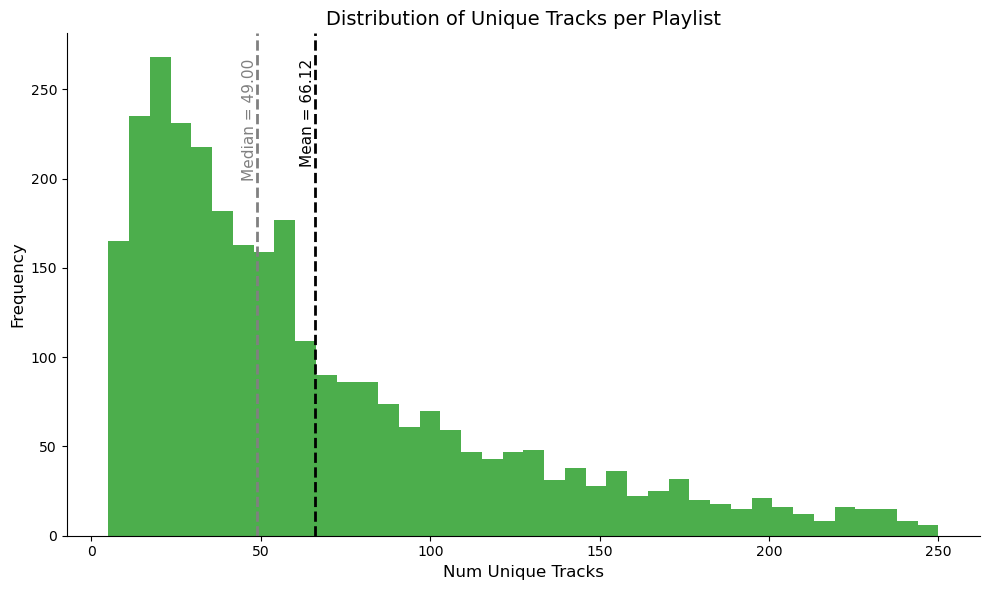

Figure saved to: plots/unique_artists.png


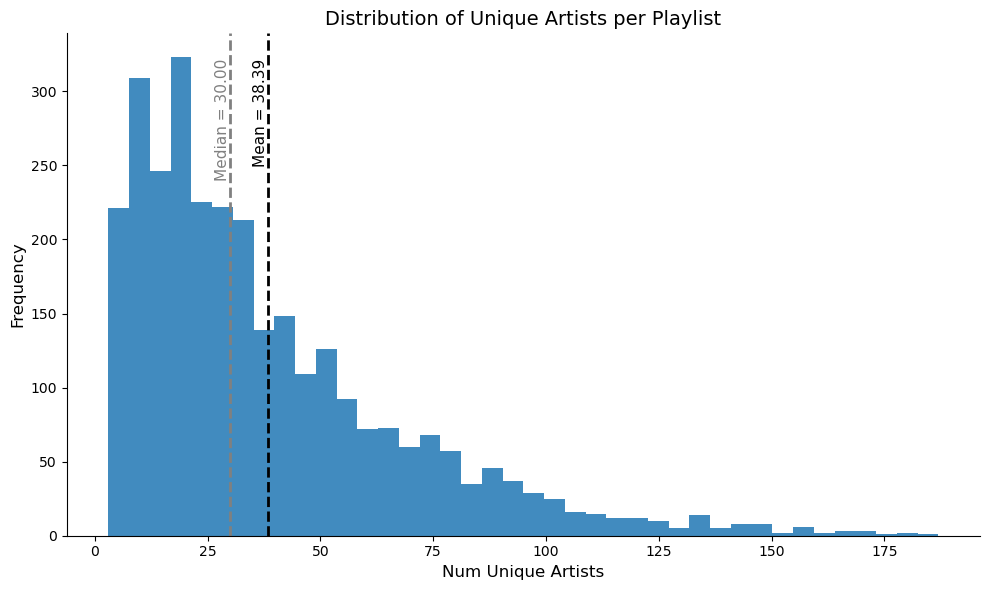

Figure saved to: plots/unique_albums.png


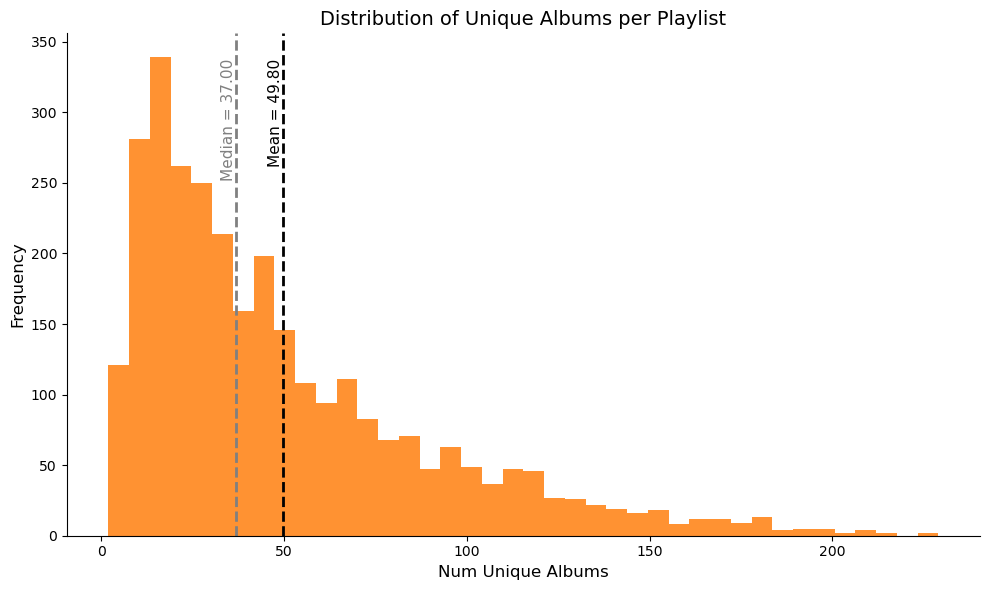

In [13]:
# --------------------------------------------------------
# df_agg must contain:
#   'num_unique_tracks'
#   'num_unique_artists'
#   'num_unique_albums'
# --------------------------------------------------------

def plot_distribution(df, column, title, color, save_path):
    """
    Plots a clean histogram for df[column] including:
      - no gridlines
      - minimalistic style
      - vertical line marking the mean
    """

    values = df[column].dropna()

    plt.style.use("default")
    fig, ax = plt.subplots(figsize=(10, 6))

    # Histogram
    ax.hist(
        values,
        bins=40,
        alpha=0.85,
        color=color
    )

    # Compute and draw mean indicator
    mean_val = values.mean()
    ax.axvline(mean_val, color="black", linestyle="--", linewidth=2)
    ax.text(
        mean_val,
        ax.get_ylim()[1] * 0.95,
        f"Mean = {mean_val:.2f}",
        rotation=90,
        verticalalignment="top",
        horizontalalignment="right",
        fontsize=11,
        color="black"
    )
      # Compute and draw median indicator
    median_val = values.median()
    ax.axvline(median_val, color="grey", linestyle="--", linewidth=2)
    ax.text(
        median_val,
        ax.get_ylim()[1] * 0.95,
        f"Median = {median_val:.2f}",
        rotation=90,
        verticalalignment="top",
        horizontalalignment="right",
        fontsize=11,
        color="grey"
    )

    # Clean visualization aesthetics
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.set_xlabel(column.replace("_", " ").title(), fontsize=12)
    ax.set_ylabel("Frequency", fontsize=12)
    ax.set_title(title, fontsize=14)

    plt.tight_layout()
    
    # Save figure if a path is specified
    if save_path is not None:
        # Ensure directory exists
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        fig.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Figure saved to: {save_path}")
    plt.show()


# --------------------------------------------------------
# Generate the 3 separate plots
# --------------------------------------------------------

plot_distribution(
    df_agg,
    "num_unique_tracks",
    "Distribution of Unique Tracks per Playlist",
    "#2ca02c",   # green
    save_path="plots/unique_tracks.png"

)

plot_distribution(
    df_agg,
    "num_unique_artists",
    "Distribution of Unique Artists per Playlist",
    "#1f77b4",   # blue
    save_path="plots/unique_artists.png"
)

plot_distribution(
    df_agg,
    "num_unique_albums",
    "Distribution of Unique Albums per Playlist",
    "#ff7f0e",   # orange
    save_path="plots/unique_albums.png"

)


In [14]:
df_agg, extras = compute_playlist_aggregates(df_full)
#df_agg.to_excel("playlist_aggregates.xlsx")


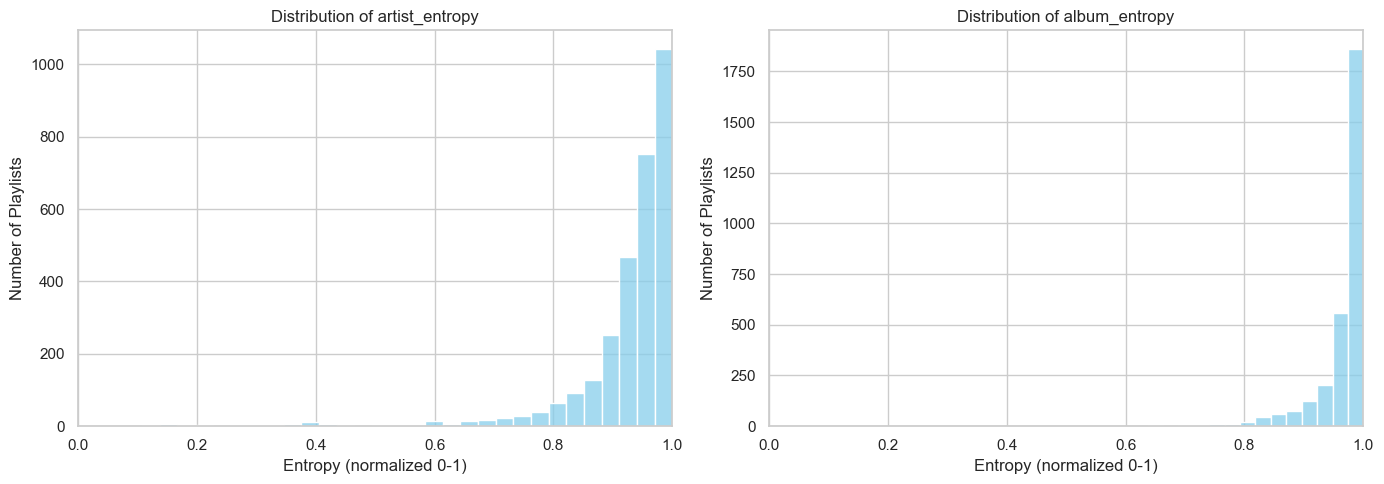

In [15]:
sns.set(style="whitegrid")

entropy_cols = ['artist_entropy', 'album_entropy']
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, col in zip(axes, entropy_cols):
    sns.histplot(df_agg[col], bins=30, ax=ax, color='skyblue')
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel('Entropy (normalized 0-1)')
    ax.set_ylabel('Number of Playlists')
    ax.set_xlim(0, 1)

plt.tight_layout()
plt.show()

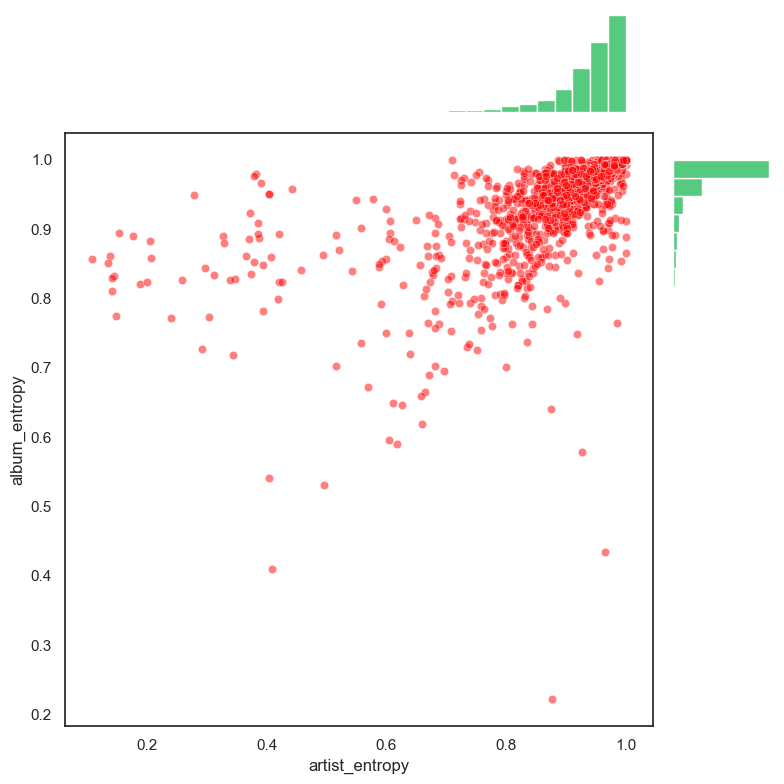

In [16]:

# Turn OFF grid globally
sns.set(style="white", rc={"axes.grid": False})

g = sns.jointplot(
    data=df_agg,
    x="artist_entropy",
    y="album_entropy",
    kind="scatter",
    color="red",
    alpha=0.5,
    marginal_kws=dict(bins=30, fill=True, color="#1DB954"),
    height=8
)

# Keep spines for joint plot (scatter)
joint_ax = g.ax_joint

for spine in ["top", "right", "left", "bottom"]:
    joint_ax.spines[spine].set_visible(True)

# Remove spines for marginal plots only
for ax in [g.ax_marg_x, g.ax_marg_y]:
    for spine in ["top", "right", "left", "bottom"]:
        ax.spines[spine].set_visible(False)

plt.show()
g.fig.savefig("plots/entropy.png", dpi=150, bbox_inches="tight")

**First observations**

From the above, we can already observe that artist and album entropy is high in the extracted dataset, suggesting that playlists contain tracks from a wide variety of artists and albums in most cases. 

# Investigate Extras data

In [17]:
extras['top_artists'][0]

[('Jesse McCartney', 4),
 ('Chris Brown', 3),
 ('Justin Bieber', 3),
 ('Ne-Yo', 2),
 ('Beyoncé', 2)]

In [18]:
# Flatten top_artists into a long table
records = []
for pid, artist_list in extras['top_artists'].items():
    for rank, (artist_name, count) in enumerate(artist_list, start=1):
        records.append({
            "pid": pid,
            "artist_name": artist_name,
            "count_in_playlist": count,
            "rank_in_playlist": rank
        })
df_top_artists = pd.DataFrame(records)

**Investigate artist-artist co-occurence**

In [19]:
pair_counts = Counter()

for pid, group in df_top_artists.groupby("pid"):
    artists = sorted(set(group["artist_name"].dropna()))
    for a, b in combinations(artists, 2):
        pair_counts[(a, b)] += 1

df_artist_pairs = (
    pd.DataFrame(
        [
            {"artist_a": a, "artist_b": b, "num_playlists_together": cnt}
            for (a, b), cnt in pair_counts.items()
        ]
    )
    .sort_values("num_playlists_together", ascending=False)
)

In [20]:
df_artist_pairs

,artist_a,artist_b,num_playlists_together
593,Drake,Kanye West,51
594,Drake,Kendrick Lamar,46
3137,Drake,Future,39
2035,Drake,The Weeknd,33
1174,Drake,Rihanna,31
...,...,...,...
8981,James Blake,Janelle Monáe,1
8980,Dj Bitman,Trüby Trio,1
8979,Dj Bitman,Janelle Monáe,1
8978,Dj Bitman,James Blake,1


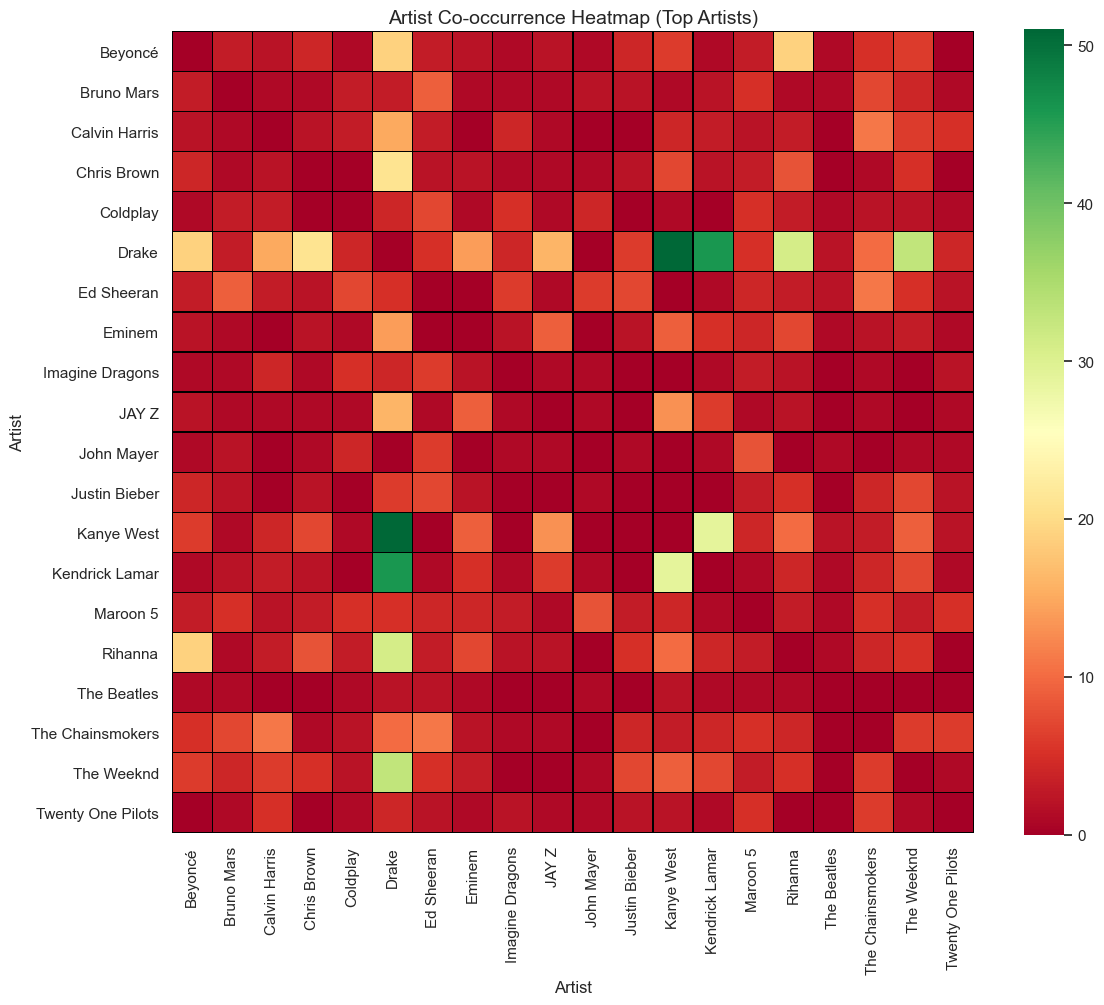

In [21]:
# Get top 10 artists by total co-occurrence
top_artists = pd.Series(df_artist_pairs["artist_a"]
                        .tolist() + df_artist_pairs["artist_b"].tolist()
                           ).value_counts().head(20).index.tolist()

# Filter to those pairs
mask = df_artist_pairs["artist_a"].isin(top_artists) & df_artist_pairs["artist_b"].isin(top_artists)
df_pairs_small = df_artist_pairs[mask]

# Build matrix
artists_sorted = sorted(top_artists)
matrix = pd.DataFrame(0, index=artists_sorted, columns=artists_sorted, dtype=int) 

for _, row in df_pairs_small.iterrows():
    a, b, w = row["artist_a"], row["artist_b"], row["num_playlists_together"]
    matrix.loc[a, b] = w #diagonal will stay 0 to not disrupt the outcome (we want to show significant co-occurences and not those created by construction)
    matrix.loc[b, a] = w

plt.figure(figsize=(12, 10))

sns.heatmap(
    matrix,
    cmap="RdYlGn",        
    linewidths=0.2,       # thin gridlines 
    linecolor="black",    # makes cells clearer
    square=True
)

plt.title("Artist Co-occurrence Heatmap (Top Artists)", fontsize=14)
plt.xlabel("Artist", fontsize=12)
plt.ylabel("Artist", fontsize=12)
plt.tight_layout()
plt.savefig("plots/co_occurences_heatmap.png")
plt.show()


In [22]:
# Merge top artists with playlist-level entropies
df_artist_playlists = (df_top_artists
    .merge(
        df_agg[["artist_entropy", "album_entropy"]],
        left_on="pid",
        right_index=True,
        how="left",
    )
)

# Aggregate per artist
df_artist_summary = (
    df_artist_playlists
    .groupby("artist_name")
    .agg(
        n_playlists=("pid", "nunique"),
        avg_rank=("rank_in_playlist", "mean"),
        avg_artist_entropy=("artist_entropy", "mean"),
        avg_album_entropy=("album_entropy", "mean"),
    )
    .sort_values("n_playlists", ascending=False)
)


In [ ]:
df_artist_summary.head()

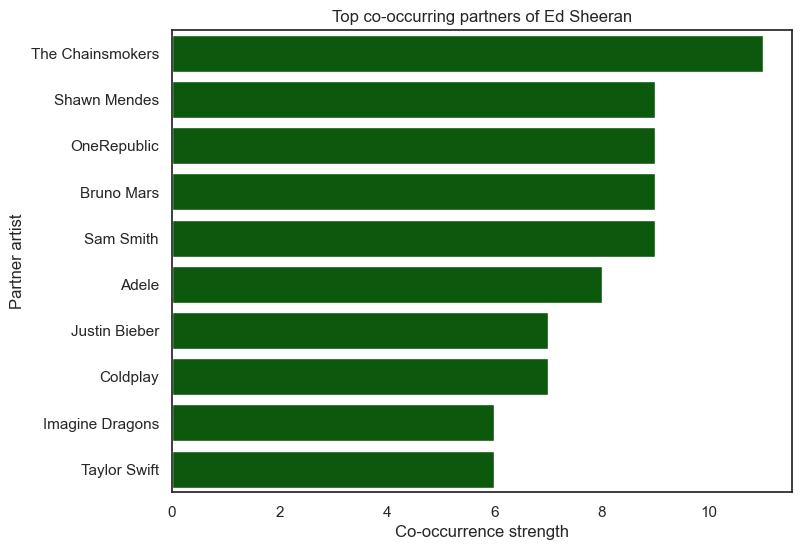

In [23]:
df_pairs_long = pd.concat([
    df_artist_pairs.rename(columns={"artist_a": "artist", "artist_b": "partner"}),
    df_artist_pairs.rename(columns={"artist_b": "artist", "artist_a": "partner"})
], ignore_index=True)

df_artist_co_stats = (
    df_pairs_long
    .groupby("artist")
    .agg(
        num_distinct_partners=("partner", "nunique"),
        total_pair_strength=("num_playlists_together", "sum"),
        strongest_single_pair=("num_playlists_together", "max")
    )
    .sort_values("total_pair_strength", ascending=False)
)


#Focus on specific artists
target_artist = "Ed Sheeran"   # example — replace with any artist name

df_drake_partners = (
    df_pairs_long
    .query("artist == @target_artist")
    .sort_values("num_playlists_together", ascending=False)
)

df_drake_partners.head()
plt.figure(figsize=(8,6))
sns.barplot(
    data=df_drake_partners.head(10),
    x="num_playlists_together",
    y="partner",
    color="darkgreen"
)
plt.title(f"Top co-occurring partners of {target_artist}")
plt.xlabel("Co-occurrence strength")
plt.ylabel("Partner artist")
plt.show()

# Question 3 - similarity between tracks

In [24]:
# ------------------------------------------------------------------
# Build a simple track feature table including genre
# ------------------------------------------------------------------

df_track_features = (
    df_full_enriched
    .dropna(subset=["track_uri"])
    .drop_duplicates(subset=["track_uri"])
    [["track_uri", "artist_uri", "album_uri", "duration_ms_track",
      "track_name", "artist_name", "album_name", "genre"]]   # <-- CHANGED HERE
    .set_index("track_uri")
)

# Convert genre strings into clean lists
df_track_features["genre"] = (
    df_track_features["genre"]
    .fillna("")
    .apply(lambda g: [x.strip().lower() for x in g.split(",") if x.strip()])
)

def _get_track_info(track_id: str):
    return df_track_features.loc[track_id]

def genre_similarity(genres1, genres2):
    """
    Jaccard similarity over genre lists.
    Returns None if either has no genre, so genre is ignored.
    """
    if not genres1 or not genres2:
        return None

    set1, set2 = set(genres1), set(genres2)
    inter = len(set1 & set2)
    union = len(set1 | set2)

    if union == 0:
        return None

    return inter / union

import numpy as np

def metadata_similarity(track_id_1: str,
                        track_id_2: str,
                        max_duration_diff_sec: float = 150.0) -> float:

    if track_id_1 == track_id_2:
        return 1.0

    try:
        t1 = _get_track_info(track_id_1)
        t2 = _get_track_info(track_id_2)
    except KeyError:
        return 0.0

    # Artist and album match
    same_artist = 1.0 if t1["artist_uri"] == t2["artist_uri"] else 0.0
    same_album  = 1.0 if t1["album_uri"]  == t2["album_uri"]  else 0.0

    # Duration similarity (smooth exponential)
    d1 = (t1["duration_ms_track"] or 0) / 1000.0
    d2 = (t2["duration_ms_track"] or 0) / 1000.0
    diff = abs(d1 - d2)
    duration_closeness = float(np.exp(-diff / max_duration_diff_sec))

    # GENRE similarity from 'genre' column
    s_genre = genre_similarity(t1["genre"], t2["genre"])

    # Base weights
    weights = {
        "genre": 0.40,
        "artist": 0.30,
        "album": 0.15,
        "duration": 0.15,
    }

    # If genre missing, remove weight and renormalize
    if s_genre is None:
        del weights["genre"]
        total = sum(weights.values())
        for k in weights:
            weights[k] /= total

    # Combine components
    sim = (
        (weights.get("genre", 0) * (s_genre if s_genre is not None else 0)) +
        (weights["artist"] * same_artist) +
        (weights["album"] * same_album) +
        (weights["duration"] * duration_closeness)
    )

    return float(max(0.0, min(1.0, sim)))



In [25]:
from collections import defaultdict

track_to_playlists = defaultdict(set)

for _, row in df_full[["track_uri", "pid"]].dropna(subset=["track_uri"]).iterrows():
    track_to_playlists[row["track_uri"]].add(row["pid"])

TOTAL_PLAYLISTS = len(df_full["pid"].unique())


def collaborative_similarity(track_id_1: str, track_id_2: str) -> float:
    """
    Collaborative similarity using normalized PMI.
    """
    if track_id_1 == track_id_2:
        return 1.0

    P1 = track_to_playlists.get(track_id_1, set())
    P2 = track_to_playlists.get(track_id_2, set())

    if not P1 or not P2:
        return 0.0

    inter = len(P1 & P2)
    if inter == 0:
        return 0.0

    p_ab = inter / TOTAL_PLAYLISTS
    p_a = len(P1) / TOTAL_PLAYLISTS
    p_b = len(P2) / TOTAL_PLAYLISTS

    pmi = math.log(p_ab / (p_a * p_b))

    sim = 1 / (1 + math.exp(-pmi))
    return float(sim)


In [26]:
def track_similarity(track_id_1: str,
                     track_id_2: str,
                     alpha: float = 0.55) -> float:
    """
    Final similarity combining metadata + PMI collaborative similarity.
    """
    s_meta = metadata_similarity(track_id_1, track_id_2)
    s_collab = collaborative_similarity(track_id_1, track_id_2)

    sim = alpha * s_meta + (1 - alpha) * s_collab
    return float(max(0.0, min(1.0, sim)))

In [28]:
subset_track_ids = df_track_features.index[:20].tolist()

similarity_matrix = pd.DataFrame(index=subset_track_ids,
                                 columns=subset_track_ids,
                                 dtype=float)
start_time = time.time()

for t1 in subset_track_ids:
    for t2 in subset_track_ids:
        similarity_matrix.loc[t1, t2] = track_similarity(t1, t2)
end_time = time.time()
elapsed = end_time - start_time
print(elapsed)
        
labels = (df_track_features["track_name"] + " — " + df_track_features["artist_name"]).to_dict()
similarity_matrix = similarity_matrix.rename(index=labels, columns=labels)

similarity_matrix.to_excel("sim_matrix.xlsx")
similarity_matrix.head()


0.06990194320678711


<ipython-input-28-914ffba28fed>:18: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.8' currently installed).
  similarity_matrix.to_excel("sim_matrix.xlsx")


,Lose Control (feat. Ciara & Fat Man Scoop) — Missy Elliott,Toxic — Britney Spears,Crazy In Love — Beyoncé,Rock Your Body — Justin Timberlake,It Wasn't Me — Shaggy,Yeah! — Usher,My Boo — Usher,Buttons — The Pussycat Dolls,Say My Name — Destiny's Child,Hey Ya! - Radio Mix / Club Mix — OutKast,Promiscuous — Nelly Furtado,Right Where You Want Me - Radio Edit Version — Jesse McCartney,Beautiful Soul — Jesse McCartney,Leavin' — Jesse McCartney,Me & U — Cassie,Ice Box — Omarion,Sk8er Boi — Avril Lavigne,Run It! — Chris Brown,Check On It - feat. Bun B and Slim Thug — Beyoncé,"Jumpin', Jumpin' — Destiny's Child"
Lose Control (feat. Ciara & Fat Man Scoop) — Missy Elliott,1.000000,0.544908,0.560673,0.699301,0.554653,0.536548,0.723969,0.738680,0.529777,0.560500,0.726297,0.563727,0.543830,0.710032,0.696067,0.547267,0.546633,0.740318,0.550196,0.571368
Toxic — Britney Spears,0.544908,1.000000,0.533877,0.513449,0.509723,0.501415,0.474097,0.553447,0.508643,0.505836,0.524576,0.565342,0.540665,0.551994,0.553819,0.512634,0.540875,0.534005,0.553561,0.491276
Crazy In Love — Beyoncé,0.560673,0.533877,1.000000,0.539255,0.526429,0.543369,0.522871,0.557566,0.530075,0.556152,0.542851,0.550230,0.538825,0.540679,0.520433,0.523167,0.512621,0.559987,0.805003,0.542678
Rock Your Body — Justin Timberlake,0.699301,0.513449,0.539255,1.000000,0.528880,0.550925,0.711295,0.713096,0.557152,0.527905,0.716337,0.529293,0.499411,0.675438,0.707424,0.554859,0.520806,0.704070,0.526633,0.538017
It Wasn't Me — Shaggy,0.554653,0.509723,0.526429,0.528880,1.000000,0.530808,0.558312,0.534461,0.518751,0.538068,0.539859,0.531767,0.493886,0.505375,0.529777,0.541488,0.516301,0.563466,0.488203,0.552965


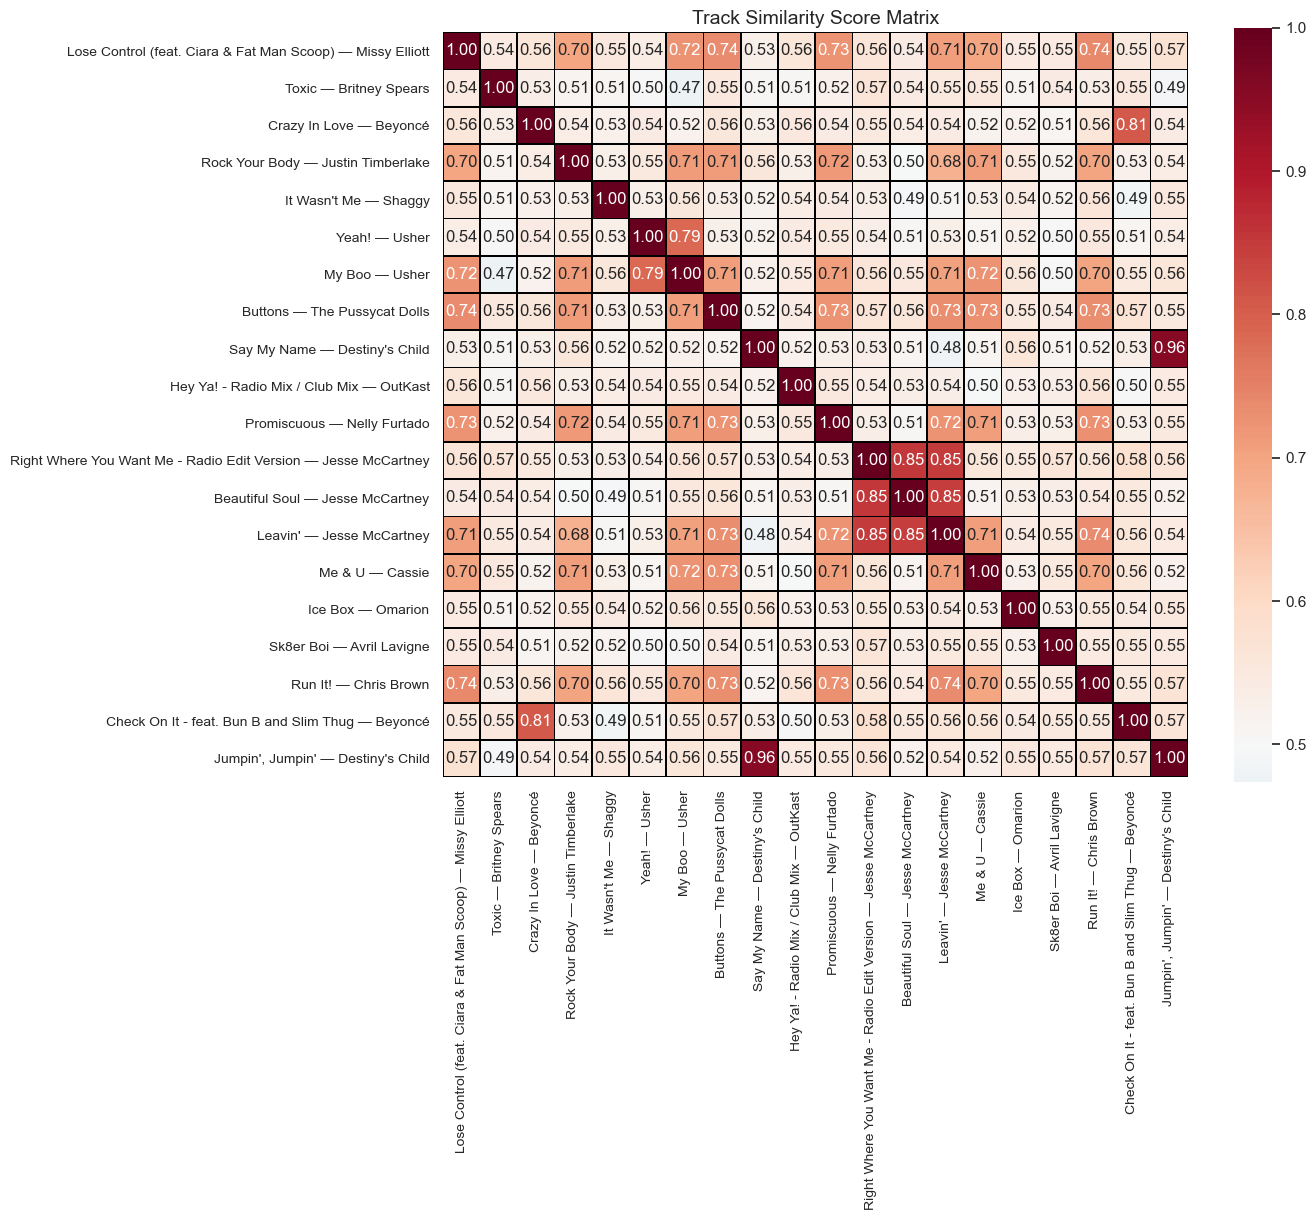

In [29]:

plt.figure(figsize=(14, 12))

sns.heatmap(
    similarity_matrix,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",    
    center=0.5,        # anchor midpoint around 0.5 similarity
    linewidths=0.5,
    linecolor="black",
    square=True
)

plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)

plt.title("Track Similarity Score Matrix", fontsize=14)
plt.tight_layout()
plt.savefig("plots/similarity_matrix_excelstyle.png", dpi=300)
plt.show()


# Question 4 - Similarity between playlists

**Standard approach**

In [30]:
from tqdm import tqdm

# Build dictionary: playlist → set of track_ids
playlist_tracks = (
    df_full.groupby("pid")["track_id"]
           .apply(set)
           .to_dict()
)

def jaccard(a, b):
    """Compute Jaccard similarity between two sets."""
    inter = len(a & b)
    union = len(a | b)
    if union == 0:
        return 0.0
    return inter / union


def compute_jaccard_all(playlists_dict, sample_fraction=0.01):
    """
    Compute Jaccard similarity for all playlist pairs
    but only using a sample_fraction of playlists for speed.
    """
    pids = list(playlists_dict.keys())
    sample_size = int(len(pids) * sample_fraction)
    pids_sample = pids[:sample_size]

    results = {}

    for pid in tqdm(pids_sample):
        A = playlists_dict[pid]

        sims = []
        for other_pid in pids_sample:
            if pid == other_pid:
                continue
            score = jaccard(A, playlists_dict[other_pid])
            sims.append((other_pid, score))

        sims_sorted = sorted(sims, key=lambda x: x[1], reverse=True)
        results[pid] = sims_sorted[:4]

    return results




In [31]:
jaccard_results = compute_jaccard_all(playlist_tracks)


100%|████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 9669.49it/s]


In [32]:
for pid, sims in list(jaccard_results.items())[:2]:
    print(f"\nPlaylist {pid}:")
    for other, score in sims:
        print(f"  Similar Playlist {other} - Jaccard: {score:.4f}")


Playlist 0:
  Similar Playlist 5 - Jaccard: 0.0244
  Similar Playlist 17 - Jaccard: 0.0078
  Similar Playlist 14 - Jaccard: 0.0066
  Similar Playlist 1 - Jaccard: 0.0000

Playlist 1:
  Similar Playlist 14 - Jaccard: 0.0071
  Similar Playlist 0 - Jaccard: 0.0000
  Similar Playlist 2 - Jaccard: 0.0000
  Similar Playlist 3 - Jaccard: 0.0000


**Dask Approach**

In [34]:
import dask.bag as db
client = Client()  # you can pass processes=False for threads only
client


C:\Users\Clara\anaconda3\lib\site-packages\distributed\dashboard\core.py:18: UserWarning: 
Dask needs bokeh!=3.0.*,>=2.4.2 for the dashboard.
You have bokeh=2.3.2.
Continuing without the dashboard.
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 15.93 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:56397,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 15.93 GiB
Comm: tcp://127.0.0.1:56416,Total threads: 4
Dashboard: http://127.0.0.1:56420/status,Memory: 3.98 GiB
Nanny: tcp://127.0.0.1:56400,


In [35]:
# 2.1 Build: pid -> set(track_id)
playlist_tracks_full = (
    df_full.groupby("pid")["track_id"]
           .apply(set)
           .to_dict()
)

print(f"Total playlists in df_full: {len(playlist_tracks_full)}")

# 2.2 Sample some playlists for similarity computation
SAMPLE_FRACTION = 0.01   # 1% like in your text
MIN_PLAYLISTS   = 500    # just to ensure we still have a reasonable number

all_pids = list(playlist_tracks_full.keys())
sample_size = max(int(len(all_pids) * SAMPLE_FRACTION), MIN_PLAYLISTS)

sample_pids = all_pids[:sample_size]  # or random.sample(all_pids, sample_size)

print(f"Using {len(sample_pids)} playlists for Dask similarity (sample)")


Total playlists in df_full: 3000
Using 500 playlists for Dask similarity (sample)


In [36]:
# pid -> set(track_id) restricted to the sample
playlist_tracks = {pid: playlist_tracks_full[pid] for pid in sample_pids}


In [37]:
def jaccard(set_a, set_b):
    """Compute Jaccard similarity between two sets of track IDs."""
    inter = len(set_a & set_b)
    union = len(set_a | set_b)
    if union == 0:
        return 0.0
    return inter / union


In [38]:
# Scatter the small playlist_tracks dict to workers
playlist_tracks_future = client.scatter(playlist_tracks, broadcast=True)

# We also keep a simple list of PIDs that every task will compare against
pids_all = list(playlist_tracks.keys())


In [39]:
def compute_top_k_for_pid(pid, playlist_tracks, pids_all, k=4):
    """
    Compute the top-k most similar playlists for a single playlist ID, 
    using Jaccard similarity.
    
    Parameters:
    - pid: the playlist ID to compare
    - playlist_tracks: dict pid -> set(track_id)
    - pids_all: list of all playlist IDs considered
    - k: number of neighbors to return
    
    Returns:
    - (pid, [(other_pid, score), ...]) sorted by descending score
    """
    tracks_a = playlist_tracks[pid]
    sims = []

    for other_pid in pids_all:
        if other_pid == pid:
            continue
        tracks_b = playlist_tracks[other_pid]
        score = jaccard(tracks_a, tracks_b)
        sims.append((other_pid, score))

    sims.sort(key=lambda x: x[1], reverse=True)
    return pid, sims[:k]


In [41]:
# Build a Dask bag over the sampled PIDs
bag = db.from_sequence(sample_pids, npartitions=8)

# Map the compute function over all PIDs
# NOTE: we pass `playlist_tracks_future` and `pids_all` as arguments
dask_results = bag.map(
    compute_top_k_for_pid,
    playlist_tracks=playlist_tracks_future,
    pids_all=pids_all,
    k=4
).compute()


In [42]:
rows = []
for pid, neighbors in dask_results:
    for other_pid, score in neighbors:
        rows.append({
            "pid": pid,
            "similar_pid": other_pid,
            "jaccard_score": score
        })

df_jaccard_dask = pd.DataFrame(rows)

df_jaccard_dask.head(20)


,pid,similar_pid,jaccard_score
0,0,262,0.115607
1,0,38,0.083333
2,0,355,0.080357
3,0,380,0.064706
4,1,343,0.060606
5,1,45,0.055046
6,1,243,0.051948
7,1,374,0.045455
8,2,88,0.065574
9,2,238,0.011765


In [45]:
def print_top_similar(df_results, target_pid, top_k=4):
    df_sub = (
        df_results[df_results["pid"] == target_pid]
        .sort_values("jaccard_score", ascending=False)
        .head(top_k)
    )
    if df_sub.empty:
        print(f"No similarity results found for playlist {target_pid}")
        return
    
    print(f"\nPlaylist {target_pid}:")
    for _, row in df_sub.iterrows():
        print(f"  Similar Playlist {int(row['similar_pid'])} - "
              f"Jaccard Similarity: {row['jaccard_score']:.4f}")


# Example (if 1 and 102 are in your sample_pids)
print_top_similar(df_jaccard_dask, 1, top_k=4)
print_top_similar(df_jaccard_dask, 102, top_k=4)



Playlist 1:
  Similar Playlist 343 - Jaccard Similarity: 0.0606
  Similar Playlist 45 - Jaccard Similarity: 0.0550
  Similar Playlist 243 - Jaccard Similarity: 0.0519
  Similar Playlist 374 - Jaccard Similarity: 0.0455

Playlist 102:
  Similar Playlist 306 - Jaccard Similarity: 0.1159
  Similar Playlist 335 - Jaccard Similarity: 0.0862
  Similar Playlist 454 - Jaccard Similarity: 0.0733
  Similar Playlist 285 - Jaccard Similarity: 0.0500


In [ ]:
client.close()

In [48]:
# df_jaccard_dask must exist from earlier steps
# Columns expected: "pid", "similar_pid", "jaccard_score"

# Pivot into playlist x playlist similarity matrix
similarity_matrix = df_jaccard_dask.pivot_table(
    index="pid",
    columns="similar_pid",
    values="jaccard_score",
    fill_value=0
)

similarity_matrix.head()


similar_pid,0,1,2,3,4,5,6,7,8,9,...,489,490,491,492,493,494,495,496,498,499
pid,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
#Chose most popular visualisation based on those that appear most often
top_pids = (
    df_jaccard_dask["pid"]
    .value_counts()
    .head(100)
    .index
)

sim_sub = similarity_matrix.iloc[top_pids, top_pids]



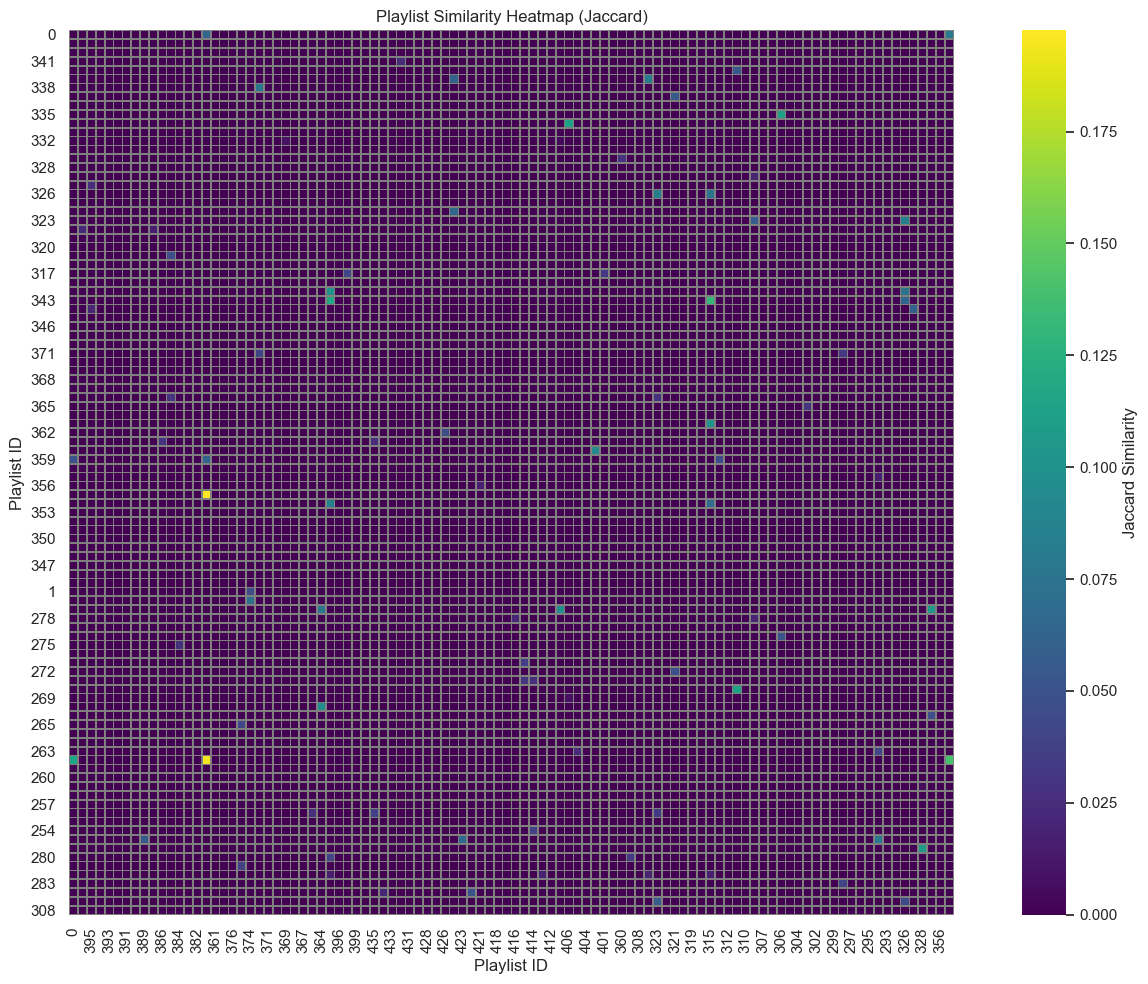

In [54]:
plt.figure(figsize=(14, 10))
sns.heatmap(
    sim_sub,
    cmap="viridis",
    linewidths=0.5,
    linecolor="gray",
    square=True,
    cbar_kws={"label": "Jaccard Similarity"}
)

plt.title("Playlist Similarity Heatmap (Jaccard)")
plt.xlabel("Playlist ID")
plt.ylabel("Playlist ID")
plt.tight_layout()
plt.show()


# Question 5 - Playlist continuation

Using the track_similarity function, we can compute a score for any track not in a playlist by summing its similarity scores with each track already present in that playlist.

In [ ]:
### Due to excessively long computation times, I limited the search to 2,000 random tracks. ###

def recommended_tracks(playlist_ref, k=2000):
    sampled_tracks = set(random.sample(list(set(track_to_playlists.keys()) - set(playlist_ref)), k))
    similarity = {}
    for track in sampled_tracks:
        similarity[track] = sum(track_similarity(track_ref, track) for track_ref in playlist_ref)
    similarity = sorted(similarity.items(), key=lambda x: x[1], reverse=True)
    return similarity

In [ ]:
recommended_tracks(playlist_to_tracks[0])[:10]

This method is computationally intensive: even with a random sample of 2,000 tracks, the program took 12 seconds to produce a result. To improve the performance, we can:
1) select a smaller, more relevant subset of tracks (for example, consider only the tracks that co-occur with at least one track from the reference playlist);
2) restrict the similarity calculation to a simpler form (for instance, using only the Jaccard similarity).

In [ ]:
### Method 1 ###

def recommended_tracks_union(playlist_ref):
    set_of_playlists = set().union(*(track_to_playlists[track] for track in playlist_ref))
    union_playlists = set().union(*(playlist_to_tracks[playlist] for playlist in set_of_playlists)) - playlist_ref
    similarity = {}
    for track in union_playlists:
        similarity[track] = sum(track_similarity(track_ref, track) for track_ref in playlist_ref)
    similarity = sorted(similarity.items(), key=lambda x: x[1], reverse=True)
    return similarity

In [ ]:
result_union = recommended_tracks_union(playlist_to_tracks[0])

In [ ]:
[(df_tracks.loc[df_tracks['track_uri'] == result_union[n][0], 'track_name'].iloc[0],
  df_tracks.loc[df_tracks['track_uri'] == result_union[n][0], 'album_name'].iloc[0],
  result_union[n][1]) for n in range(20)]

In [ ]:
### Method 2 ###

def jaccard_similarity(set1, set2):
    if len(set1 | set2) == 0:
        return 0
    return len(set1 & set2) / len(set1 | set2)

def recommended_tracks_jaccard(playlist_ref, p=1):
    similarity = {}
    for track in set(track_to_playlists.keys()).difference(playlist_ref):
        list_of_scores = []
        for track_ref in playlist_ref:
            sim = jaccard_similarity(track_to_playlists.get(track_ref, set()), track_to_playlists.get(track, set()))
            if sim != 0:
                list_of_scores.append(sim)
        if list_of_scores:
            similarity[track] = np.linalg.norm(list_of_scores, ord=p)
    similarity = sorted(similarity.items(), key=lambda x: x[1], reverse=True)
    return similarity

In [ ]:
result_jaccard = recommended_tracks_jaccard(playlist_to_tracks[0])

In [ ]:
[(df_tracks.loc[df_tracks['track_uri'] == result_jaccard[n][0], 'track_name'].iloc[0],
  df_tracks.loc[df_tracks['track_uri'] == result_jaccard[n][0], 'album_name'].iloc[0],
  result_jaccard[n][1]) for n in range(20)]

We can now compare the results of the two methods.

In [ ]:
def intersection_union_jaccard(k):
    return [track for track in [item[0] for item in result_union[:k]] if track in [item[0] for item in result_jaccard[:k]]]

In [ ]:
result_intersection = intersection_union_jaccard(20)

In [ ]:
[(df_tracks.loc[df_tracks['track_uri'] == result_intersection[n], 'track_name'].iloc[0],
  df_tracks.loc[df_tracks['track_uri'] == result_intersection[n], 'album_name'].iloc[0]) for n in range(len(result_intersection))]

If we take the top 20 recommended tracks from method 1 and method 2, we find 11 tracks in common.